# Load Dataset

In [74]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
import numpy as np
from prophet import Prophet
from datetime import datetime
from prophet.plot import plot_plotly
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.linear_model import LassoCV

In [75]:
# Load the dataset
mortality_dataset = pd.read_csv('./datasets/Weekly_Provisional_Counts_of_Deaths_by_State_and_Select_Causes__2020-2023_20250216.csv')
mortality_dataset_illinois = mortality_dataset[mortality_dataset['Jurisdiction of Occurrence'] == 'Illinois']
climate_dataset = pd.read_csv('./datasets/Climate datasets/Data Cleaning/Climate_weekly_data.csv')

# Data Pre-Processing

In [76]:
# Code for cleaning individiual datasets
relevent_mortality_columns = [
    "Jurisdiction of Occurrence",
    "MMWR Year",
    "MMWR Week",
    "Week Ending Date",
    "All Cause",
    "Natural Cause",
    "Septicemia (A40-A41)",
    "Malignant neoplasms (C00-C97)",
    "Diabetes mellitus (E10-E14)",
    "Alzheimer disease (G30)",
    "Influenza and pneumonia (J09-J18)",
    "Chronic lower respiratory diseases (J40-J47)",
    "Other diseases of respiratory system (J00-J06,J30-J39,J67,J70-J98)",
    "Nephritis, nephrotic syndrome and nephrosis (N00-N07,N17-N19,N25-N27)",
    "Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified (R00-R99)",
    "Diseases of heart (I00-I09,I11,I13,I20-I51)",
    "Cerebrovascular diseases (I60-I69)",
    "COVID-19 (U071, Multiple Cause of Death)",
    "COVID-19 (U071, Underlying Cause of Death)",
]
# Drop irrelevant columns from mortality dataset
mortality_dataset_illinois = mortality_dataset_illinois[relevent_mortality_columns]

# Create a new column called "Non Covid Deaths" that is equal to the "All Cause" column minus the COVID deaths column
mortality_dataset_illinois["Non Covid Deaths"] = mortality_dataset_illinois["All Cause"] - mortality_dataset_illinois["COVID-19 (U071, Underlying Cause of Death)"].fillna(0)

column_map = {
    "Week_Ending_Date": "Week Ending Date",
    "AWND": "Average Wind Speed (m/s)",
    "DAPR": "Number of days included in the multiday precipitation total",
    "MDPR": "Multiday precipitation total (mm)",
    "PRCP": "Precipitation (mm)",
    "SNOW": "Snowfall (cm)",
    "SNWD": "Snow Depth (cm)",
    "TAVG": "Average Temperature (C)",
    "TMAX": "Maximum Temperature (C)",
    "TMIN": "Minimum Temperature (C)",
    "TOBS": "Temperature Observed (C)",
}

# Drop irrelevant columns from climate dataset
climate_dataset = climate_dataset[column_map.keys()]
# Rename columns in climate dataset
climate_dataset.rename(columns=column_map, inplace=True)

# Convert columns to appropriate data types
mortality_dataset_illinois['Week Ending Date'] = pd.to_datetime(mortality_dataset_illinois['Week Ending Date'])
climate_dataset['Week Ending Date'] = pd.to_datetime(climate_dataset['Week Ending Date'])

# Filter the climate dataset to be till 2023-08-01 (Aug and Sept data has a lot of noise)
mortality_dataset_illinois = mortality_dataset_illinois[mortality_dataset_illinois['Week Ending Date'] < '2023-08-01']

# Merge Columns
merged_dataset = pd.merge(mortality_dataset_illinois, climate_dataset, on='Week Ending Date', how='inner')

In [77]:
label = ['Non Covid Deaths']

features = ['Average Wind Speed (m/s)', 'Number of days included in the multiday precipitation total',
           'Multiday precipitation total (mm)', 'Precipitation (mm)', 'Snowfall (cm)', 'Snow Depth (cm)',
           'Average Temperature (C)', 'Maximum Temperature (C)', 'Minimum Temperature (C)', 'Temperature Observed (C)']

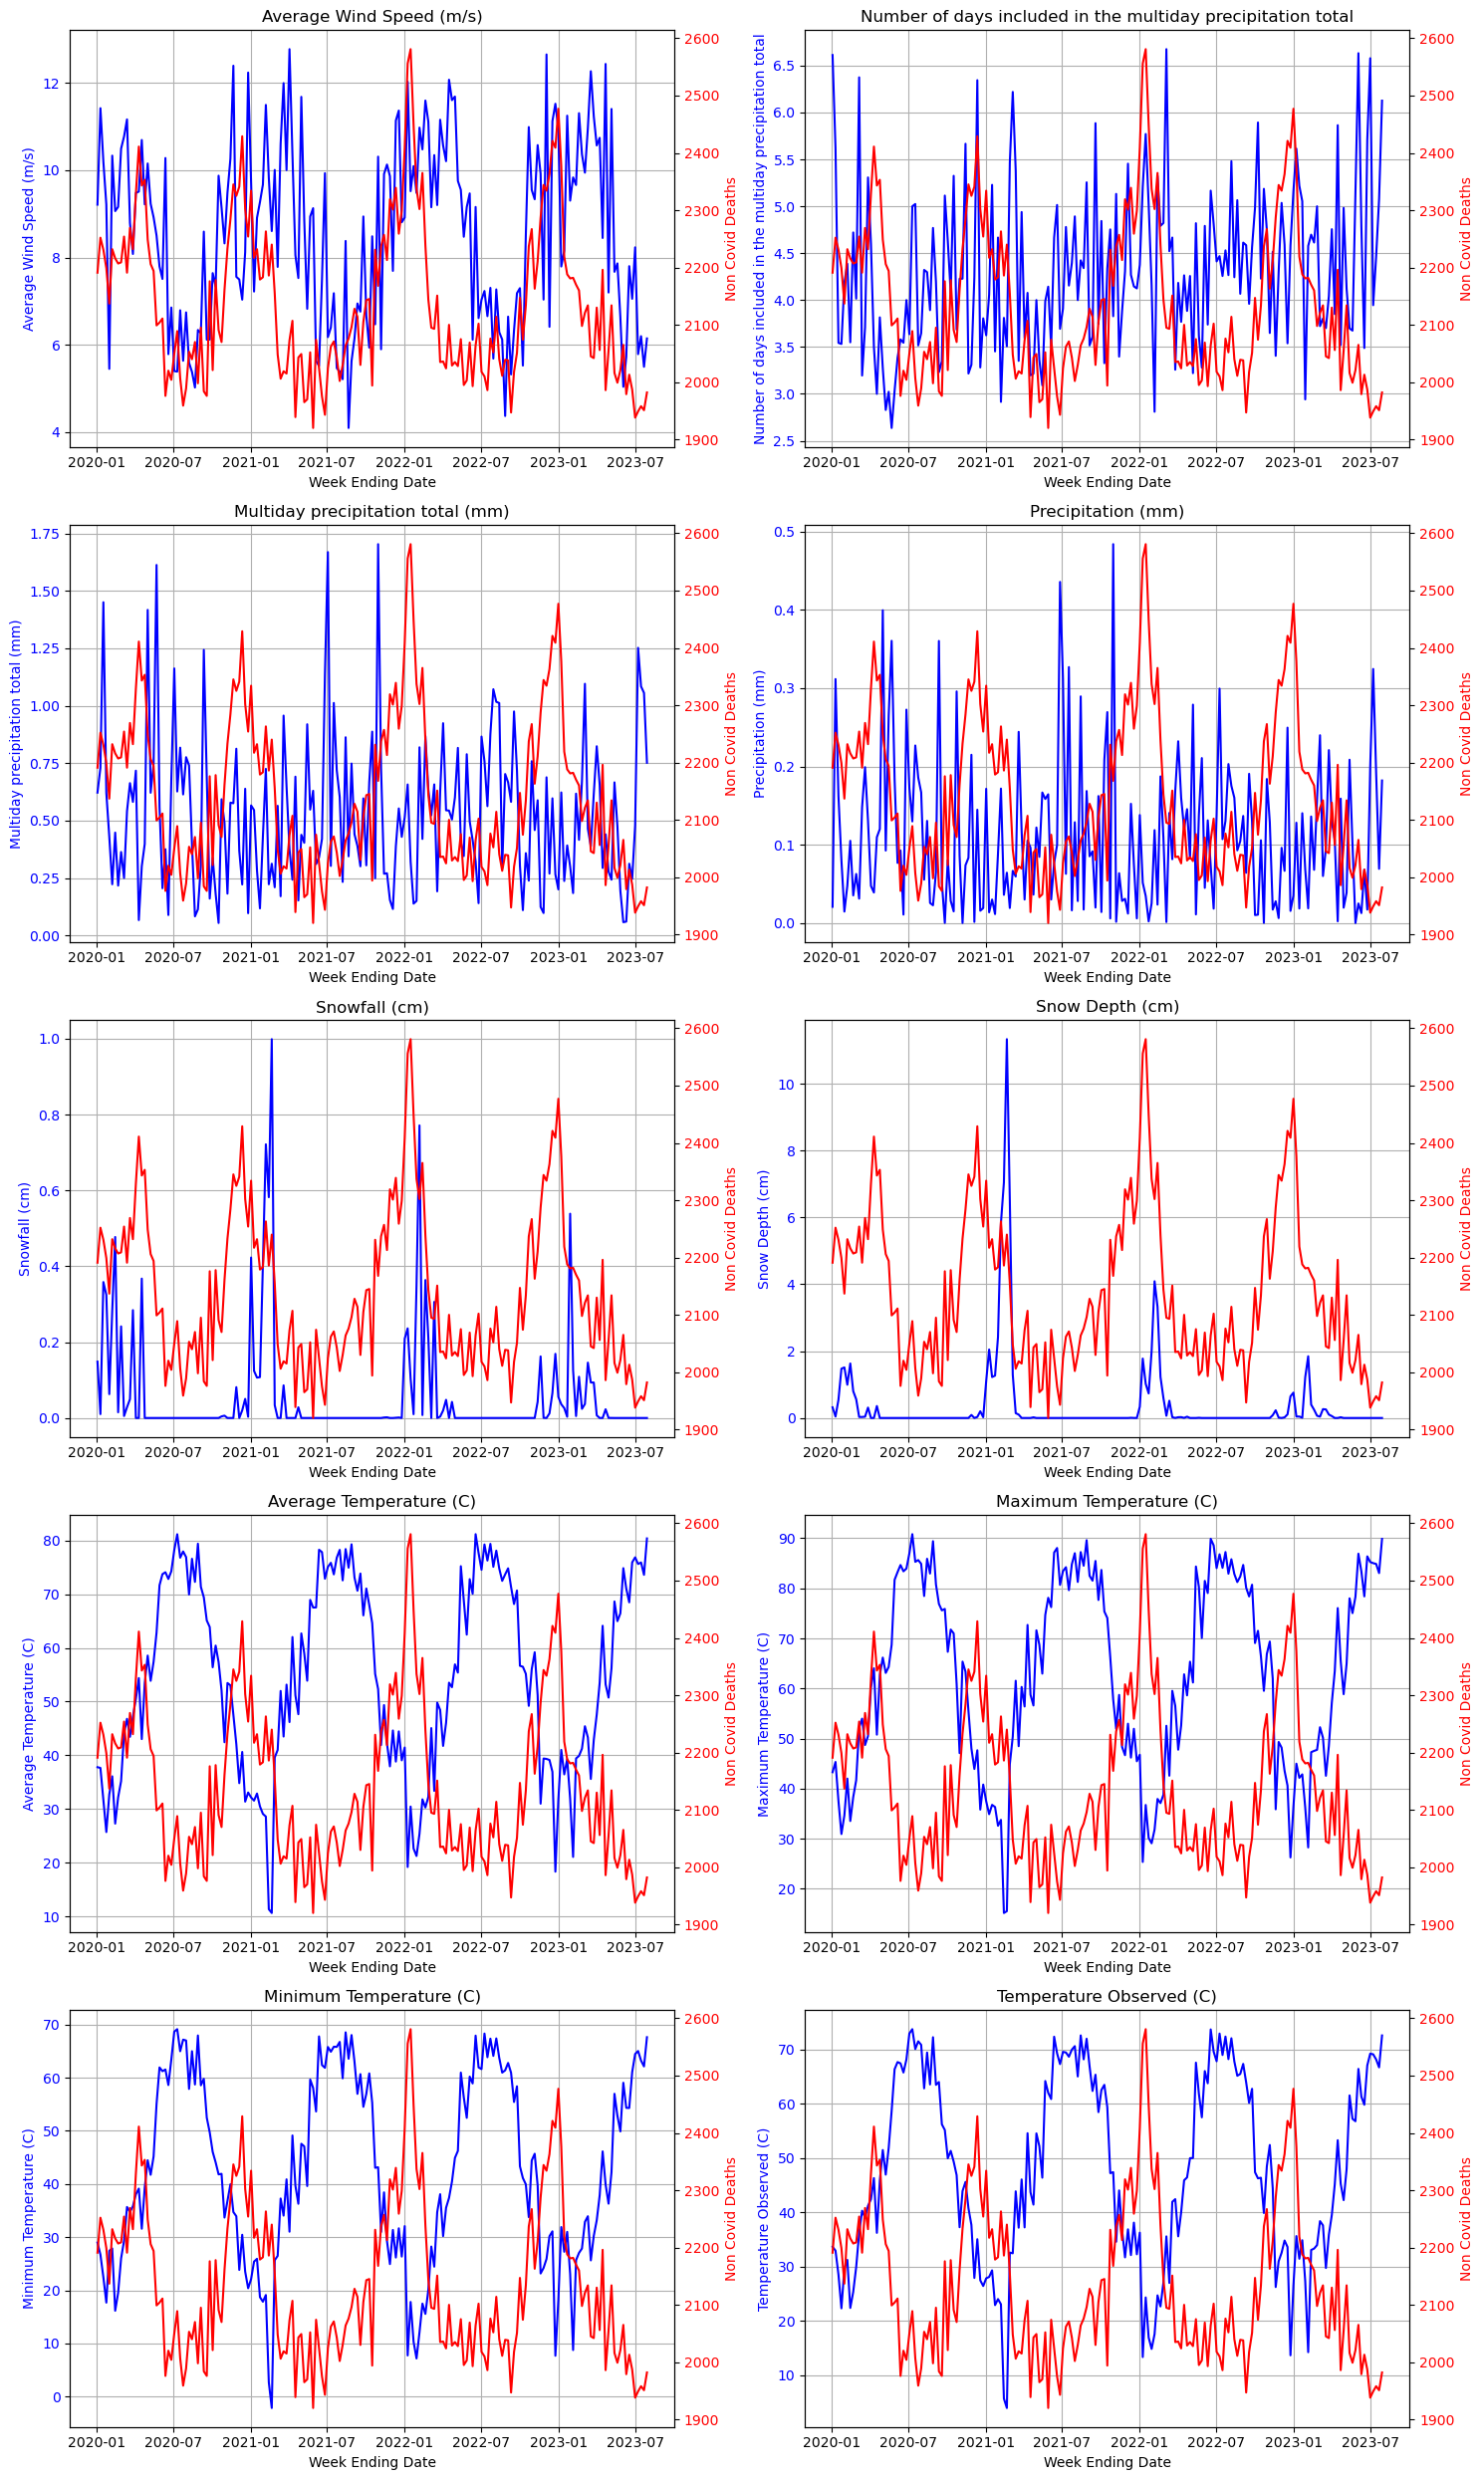

In [78]:
# Determine grid size
n_features = len(features)
n_cols = 2 
n_rows = math.ceil(n_features / n_cols)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

# Plot each feature
for i, column in enumerate(features):
    ax = axes[i]
    ax.plot(merged_dataset['Week Ending Date'], merged_dataset[column], color='blue', label=column)
    ax.set_xlabel('Week Ending Date')
    ax.set_ylabel(column, color='blue')
    ax.tick_params(axis='y', labelcolor='blue')
    ax.set_title(f'{column}')
    ax.grid()

    # Create a twin y-axis for 'Non Covid Deaths'
    ax2 = ax.twinx()
    ax2.plot(merged_dataset['Week Ending Date'], merged_dataset['Non Covid Deaths'], color='red', label='Non Covid Deaths')
    ax2.set_ylabel('Non Covid Deaths', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# Correlation

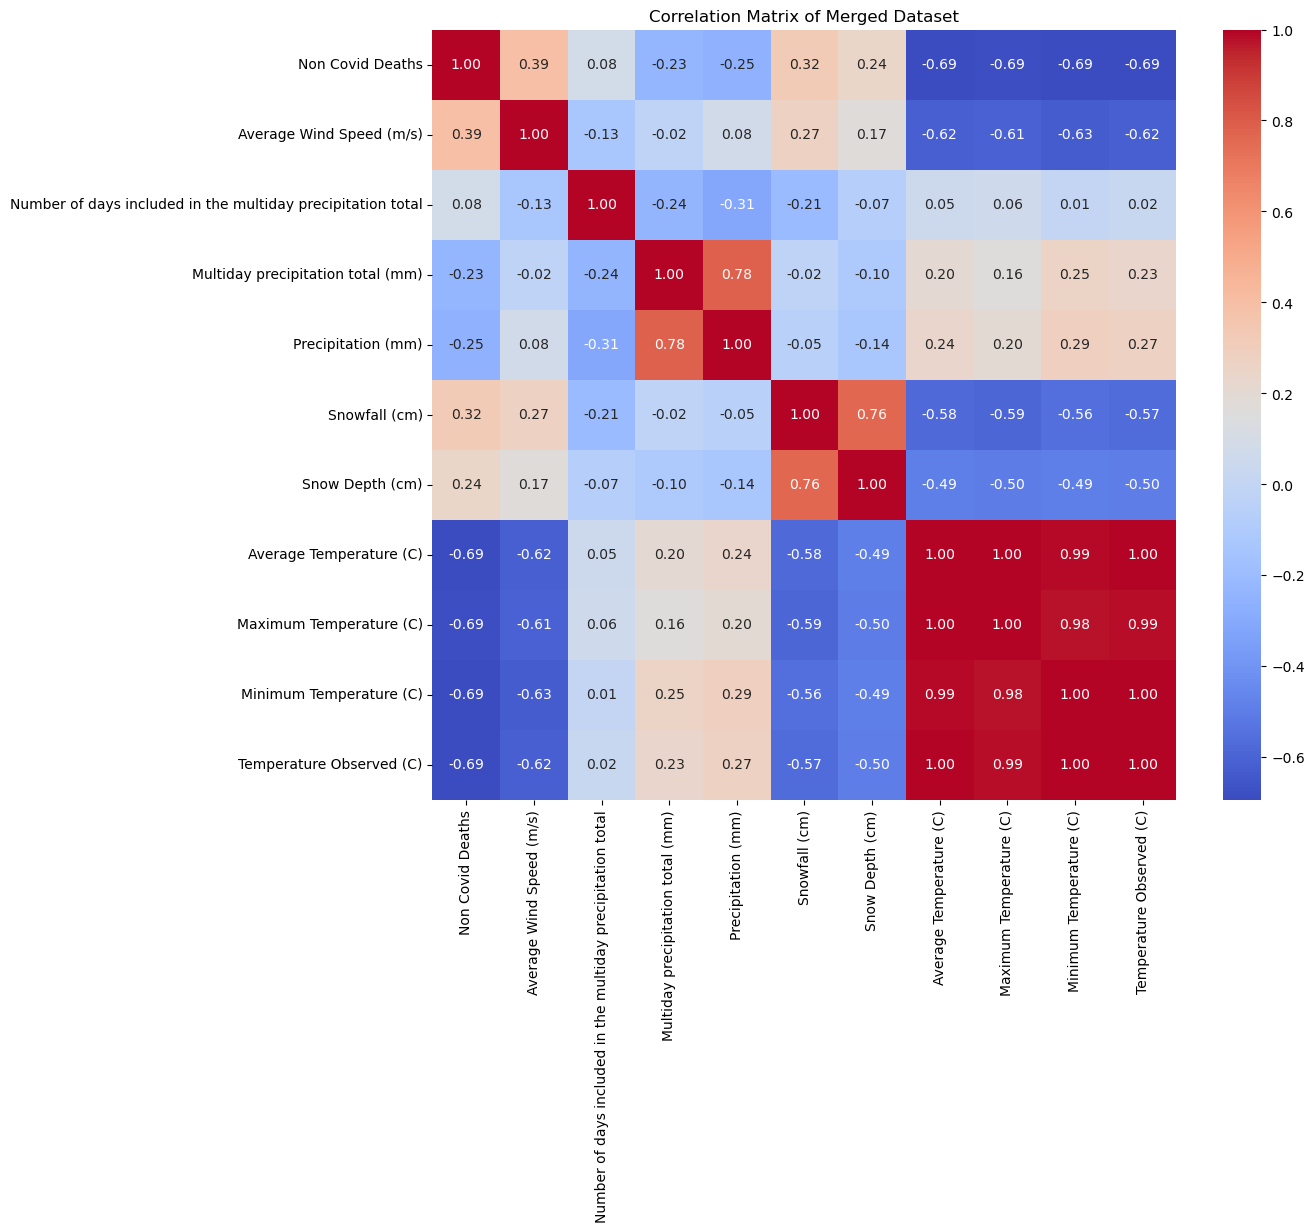

In [79]:
# Compute the correlation matrix for numeric columns only and only Non Covid Deaths
columns = ['Non Covid Deaths', 'Average Wind Speed (m/s)', 'Number of days included in the multiday precipitation total',
           'Multiday precipitation total (mm)', 'Precipitation (mm)', 'Snowfall (cm)', 'Snow Depth (cm)',
           'Average Temperature (C)', 'Maximum Temperature (C)', 'Minimum Temperature (C)', 'Temperature Observed (C)']
correlation_matrix = merged_dataset[columns].corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Merged Dataset")
plt.show()

# Feature Engineering

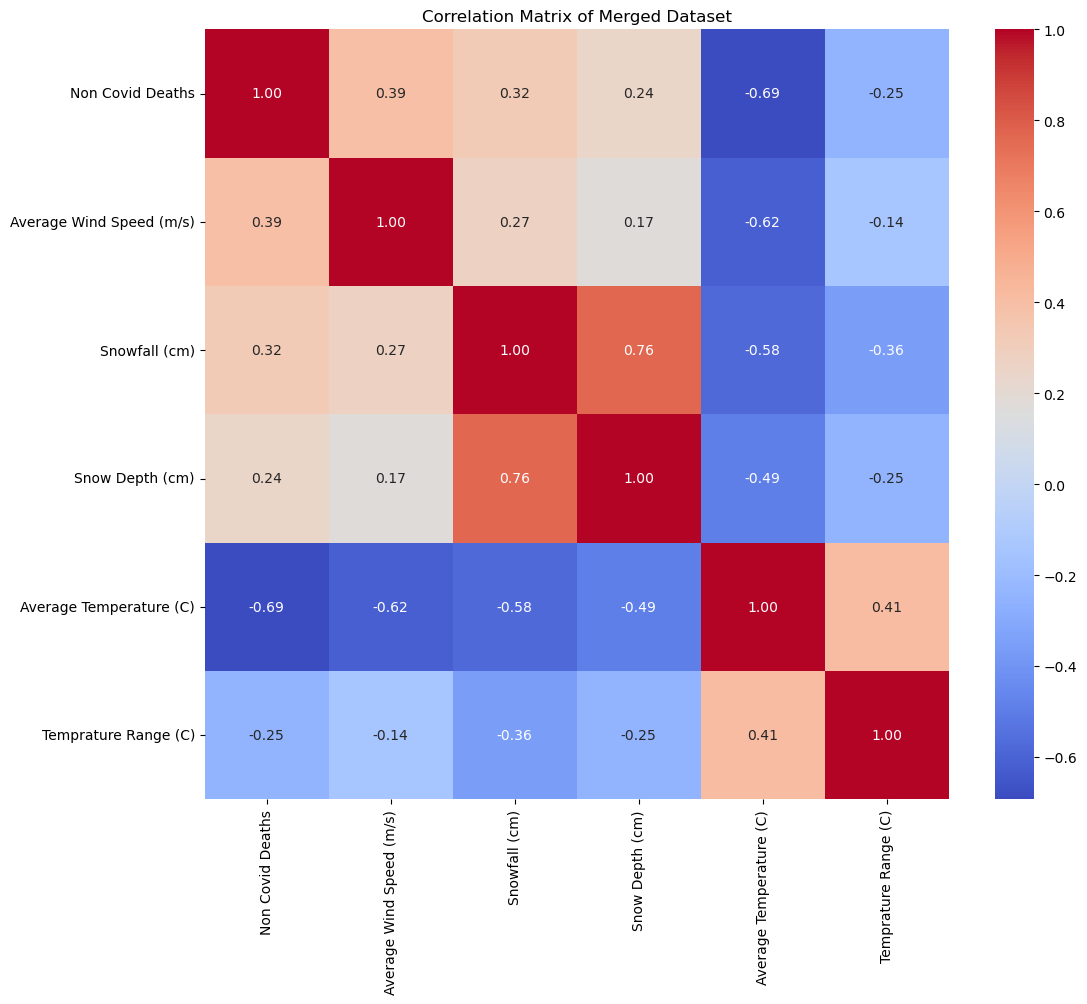

In [80]:
merged_dataset['Temprature Range (C)'] = merged_dataset['Maximum Temperature (C)'] - merged_dataset['Minimum Temperature (C)']

columns = ['Non Covid Deaths', 'Average Wind Speed (m/s)', 'Snowfall (cm)', 'Snow Depth (cm)',
           'Average Temperature (C)', 'Temprature Range (C)']

correlation_matrix = merged_dataset[columns].corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Merged Dataset")
plt.show()

# Linear Model 

In [81]:
predictors = ['Average Wind Speed (m/s)', 'Snowfall (cm)', 'Snow Depth (cm)',
              'Average Temperature (C)', 'Temprature Range (C)']
label = 'Non Covid Deaths'

X = merged_dataset[predictors]
y = merged_dataset[label]

# Initialize and fit scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Add polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_scaled)

# Use LassoCV to automatically select the best alpha
lasso_cv = LassoCV(cv=5, random_state=42)
lasso_cv.fit(X_poly, y)

# Get predictions
y_pred = lasso_cv.predict(X_poly)

# Calculate R² and adjusted R²
r2 = r2_score(y, y_pred)
n, p = X_poly.shape
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Get selected features
feature_names = poly.get_feature_names_out(predictors)
selected_features = [name for name, coef in zip(feature_names, lasso_cv.coef_) if coef != 0]

# Output results
print("Selected Features:", selected_features)
print("Best alpha:", lasso_cv.alpha_)
print("R² Score:", r2)
print("Adjusted R² Score:", adjusted_r2)

Selected Features: ['Average Temperature (C)', 'Snow Depth (cm)^2']
Best alpha: 13.427148474584314
R² Score: 0.48010026326442456
Adjusted R² Score: 0.4174617407661625


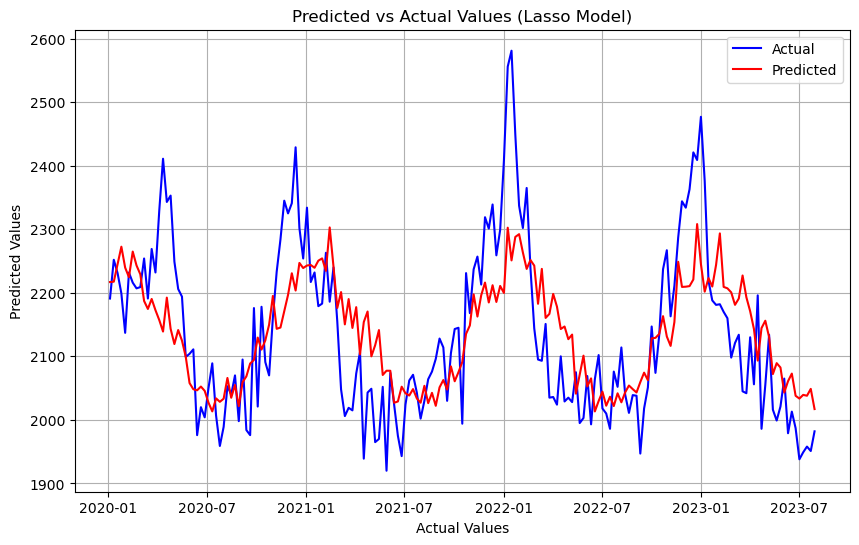

In [82]:
# Plot predicted vs actual values
plt.figure(figsize=(10, 6))
plt.plot(merged_dataset['Week Ending Date'], merged_dataset['Non Covid Deaths'], label='Actual', color='blue')
plt.plot(merged_dataset['Week Ending Date'], y_pred, label='Predicted', color='red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values (Lasso Model)')
plt.legend()
plt.grid()
plt.show()

# Prophet Model to forecast Death Count

18:09:22 - cmdstanpy - INFO - Chain [1] start processing
18:09:22 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\mohi2\.conda\envs\prompter\lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\mohi2\.conda\envs\prompter\lib\site-packages\prophet\plot.py:397: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
c:\Users\mohi2\.conda\envs\prompter\lib\site-packages\prophet\plot.py:401: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is 

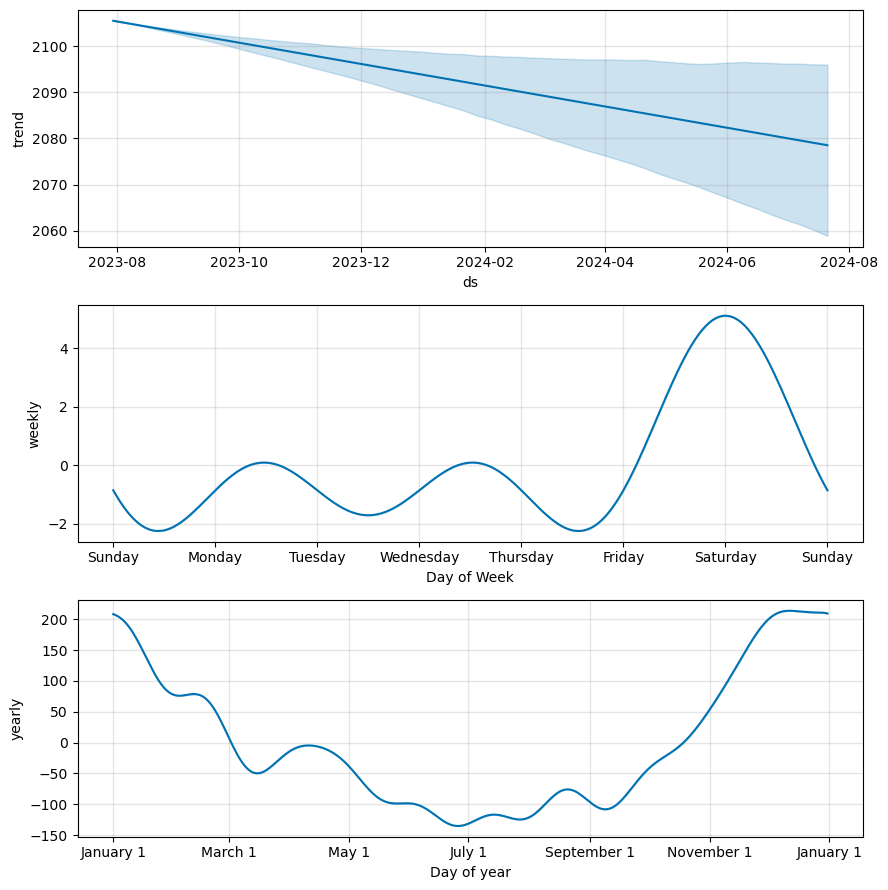

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/31 [00:00<?, ?it/s]18:09:22 - cmdstanpy - INFO - Chain [1] start processing
18:09:22 - cmdstanpy - INFO - Chain [1] done processing
  3%|▎         | 1/31 [00:00<00:06,  4.43it/s]18:09:22 - cmdstanpy - INFO - Chain [1] start processing
18:09:23 - cmdstanpy - INFO - Chain [1] done processing
  6%|▋         | 2/31 [00:00<00:06,  4.55it/s]18:09:23 - cmdstanpy - INFO - Chain [1] start processing
18:09:23 - cmdstanpy - INFO - Chain [1] done processing
 10%|▉         | 3/31 [00:00<00:06,  4.40it/s]18:09:23 - cmdstanpy - INFO - Chain [1] start processing
18:09:23 - cmdstanpy - INFO - Chain [1] done processing
 13%|█▎        | 4/31 [00:00<00:06,  4.11it/s]18:09:23 - cmdstanpy - INFO - Chain [1] start processing
18:09:23 - cmdstanpy - INFO - Chain [1] done processing
 16%|█▌        | 5/31 [00:01<00:06,  3.87it/s]18:09:23 - cmdstanpy - INFO - Chain [1] start processing
18:09:

  horizon           mse        rmse        mae      mape     mdape     smape  \
0  3 days  13208.398876  114.927799  83.977088  0.038858  0.030185  0.039480   
1  4 days  15197.218483  123.276999  93.931202  0.043592  0.033973  0.043680   
2  5 days  14359.081159  119.829384  91.706361  0.042258  0.030034  0.042670   
3  6 days   6132.105969   78.307764  64.407164  0.030852  0.025859  0.030488   
4  7 days   6333.075379   79.580622  65.069462  0.031453  0.025859  0.031010   

   coverage  
0  0.692308  
1  0.630769  
2  0.615385  
3  0.800000  
4  0.769231  


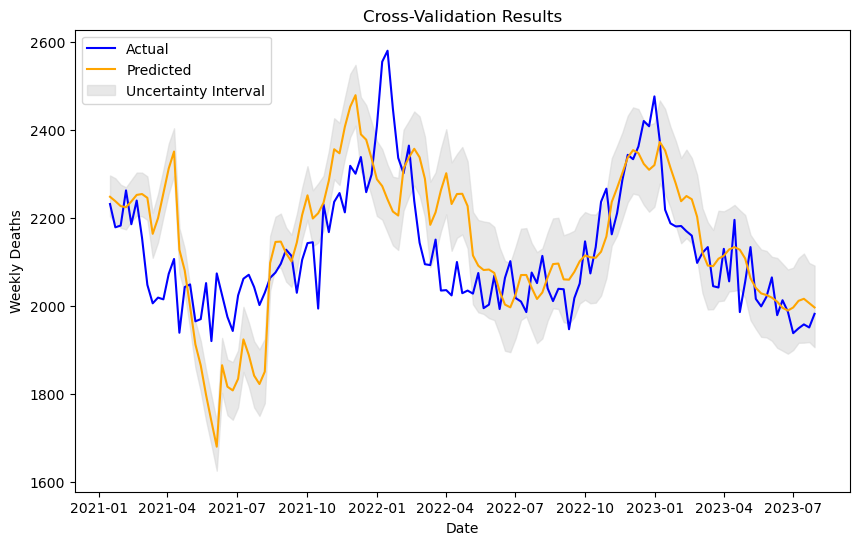

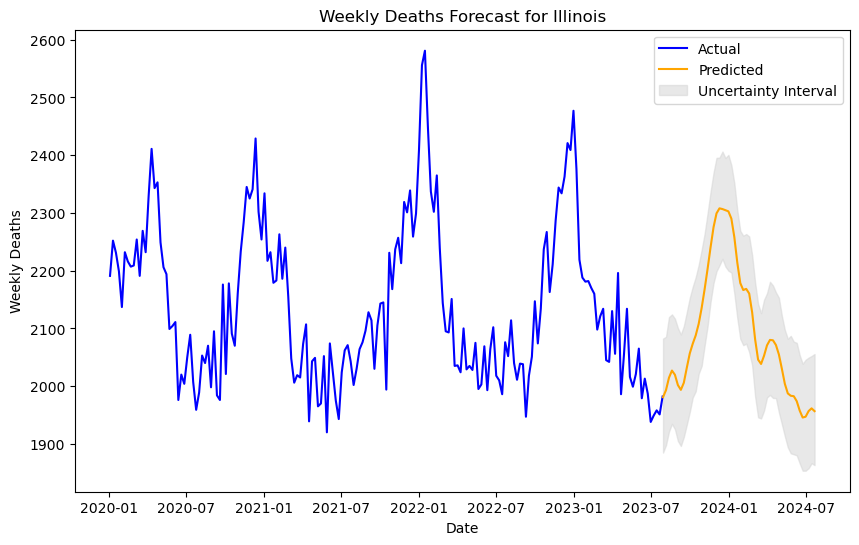

In [83]:
# Convert the date column to datetime format
prophet_dataset = mortality_dataset_illinois.rename(columns={'Week Ending Date': 'ds', 'Non Covid Deaths': 'y'}).copy()
prophet_dataset = prophet_dataset[['ds', 'y']].dropna()
prophet_dataset = prophet_dataset[(prophet_dataset['y'] > 0) & (prophet_dataset['y'] < 10000)]  # Filter rows with valid 'y' values

# Create a Prophet model
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
model.fit(prophet_dataset)

# Create a future dataframe for predictions
future = model.make_future_dataframe(periods=52, freq='W')
future = future[future['ds'] > prophet_dataset['ds'].max()]
future = future[future['ds'] < prophet_dataset['ds'].max() + pd.DateOffset(weeks=52)]

# Make predictions
forecast = model.predict(future)

# Plot the forecast components
fig2 = model.plot_components(forecast)
plt.show()
# Cross-validation
df_cv = cross_validation(model, initial='365 days', period='30 days', horizon='30 days')
df_p = performance_metrics(df_cv)
print(df_p.head())
# Plot the cross-validation results
plt.figure(figsize=(10, 6))
plt.plot(df_cv['ds'], df_cv['y'], label='Actual', color='blue')
plt.plot(df_cv['ds'], df_cv['yhat'], label='Predicted', color='orange')
plt.fill_between(df_cv['ds'], df_cv['yhat_lower'], df_cv['yhat_upper'], color='lightgray', alpha=0.5, label='Uncertainty Interval')
plt.xlabel('Date')
plt.ylabel('Weekly Deaths')
plt.title('Cross-Validation Results')
plt.legend()
plt.show()

# Plot the forecast with uncertainty intervals
plt.figure(figsize=(10, 6))
plt.plot(prophet_dataset['ds'], prophet_dataset['y'], label='Actual', color='blue')
plt.plot(forecast['ds'], forecast['yhat'], label='Predicted', color='orange')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='lightgray', alpha=0.5, label='Uncertainty Interval')
plt.xlabel('Date')
plt.ylabel('Weekly Deaths')
plt.title('Weekly Deaths Forecast for Illinois')
plt.legend()
plt.show()